In [15]:
import numpy as np  
import matplotlib.pyplot as plt 
from pandas import *
import seaborn as sns
import pandas as pd  
import pickle
import sklearn as sklearn
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import os
from os.path import dirname
parent_dir = (dirname(os.getcwd()))
sys.path.append("\\".join([parent_dir, 'model']) )

import regression
from regression import *

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
with open('out/SCSTYPEII_MGA/CORE_ALL.pickle', 'rb') as handle:
    core = pickle.load(handle)
    core_df = pd.DataFrame(core)
    
xls = ExcelFile('soils.xlsx')
soil = xls.parse(xls.sheet_names[0])
core_df.Ks_mm.unique()

array([  0.3,   0.5,   0.6,   1. ,   1.5,   3.3,   6.6,  10.9,  30. ,
       120.4])

In [3]:
#run processing function to turn initial soil conditions into categorical data
df = processing_nocat(core_df)
df=df[['fV','P_cm','A_hec','f_var','W_norm','SoilConditions','Ks_mm']]

In [4]:
# define data as df_core
# split into X and y datasets
# df=df.sample(frac=1)

feature_names = (df.drop(labels="f_var", axis=1).columns)
X_all = df[feature_names].values
y_all = pd.DataFrame(df['f_var']).values.ravel()
feature_names

# #split into training and testing sets
X_all,y_all,X_train, X_test, y_train, y_test,feature_names=split(df)
len(X_all)

60000

# Create pipeline

In [5]:
# initiate a pipeline
   
class PipelineRFE(Pipeline):
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self
    
# Sets RNG seed to reproduce results
_ = StratifiedKFold(random_state=42,shuffle=True)

pipeline = PipelineRFE([('reg', 
                         DecisionTreeRegressor(random_state = 42)),
                       ])

#test pipeline on X_train and y_train
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)
print("average of 0 (false) and 1 (true)=")
print(np.mean(preds == y_test)) #initial test of accuracy, if preds == y_test

average of 0 (false) and 1 (true)=
0.19305555555555556


# feature selection with pipeline

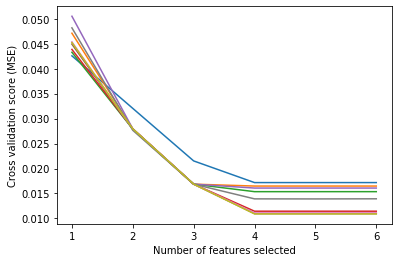

({2: ['fV', 'P_cm', 'W_norm', 'SoilConditions', 'Ks_mm'],
  3: ['fV', 'P_cm', 'SoilConditions', 'Ks_mm'],
  4: ['fV', 'P_cm', 'SoilConditions', 'Ks_mm'],
  5: ['fV', 'P_cm', 'SoilConditions', 'Ks_mm'],
  6: ['fV', 'P_cm', 'A_hec', 'W_norm', 'SoilConditions', 'Ks_mm'],
  7: ['fV', 'P_cm', 'A_hec', 'W_norm', 'SoilConditions', 'Ks_mm'],
  8: ['fV', 'P_cm', 'W_norm', 'SoilConditions', 'Ks_mm'],
  9: ['fV', 'P_cm', 'W_norm', 'SoilConditions', 'Ks_mm'],
  10: ['fV', 'P_cm', 'A_hec', 'W_norm', 'SoilConditions', 'Ks_mm']},
 {2: 5, 3: 4, 4: 4, 5: 4, 6: 6, 7: 6, 8: 5, 9: 5, 10: 6})

In [6]:
selected_feat=dict()
n_feat=dict()
def kfold(X,y):
    """

    """
    # splits X, Y  input data into X and y training and testing sets
    k=[2,3,4, 5, 6,7,8,9,10]
    plt.figure()
    for i in k:
         # splits X, Y  input data into X and y training and testing sets
        _ = StratifiedKFold(random_state=42,shuffle=True)
        feature_selector_cv = feature_selection.RFECV(pipeline,cv=i, step=1,min_features_to_select=1,
                                                      scoring='neg_mean_squared_error')
        feature_selector_cv.fit(X,y)
        feat=feature_selector_cv.n_features_
        rank=feature_selector_cv.ranking_
        cv_grid_mse = -feature_selector_cv.grid_scores_
        selected_features = feature_names[feature_selector_cv.support_].tolist()
        
        selected_feat.update({i:selected_features})
        n_feat.update({i:feat})
        
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (MSE)")
        plt.plot(range(1, len(feature_selector_cv.grid_scores_) + 1), -feature_selector_cv.grid_scores_)
    plt.show()
    return selected_feat,n_feat
    
kfold(X_all,y_all)

['fV', 'P_cm', 'SoilConditions', 'Ks_mm']


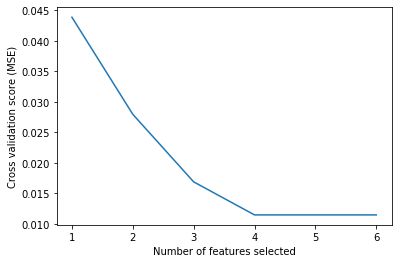

Optimal number of features : 4


In [7]:
# select best features from pipeline
# applies 5-fold cv

# selected_features,rank=feat_select(pipeline,X_all, y_all,feature_names)

_ = StratifiedKFold(random_state=42,shuffle=True)
feature_selector_cv = feature_selection.RFECV(pipeline,cv=5, step=1,min_features_to_select=1,
                                              scoring='neg_mean_squared_error')
feature_selector_cv.fit(X_all, y_all)
feature_selector_cv.n_features_
rank=feature_selector_cv.ranking_
cv_grid_mse = -feature_selector_cv.grid_scores_

selected_features = feature_names[feature_selector_cv.support_].tolist()
#cv_grid_mse = [feature_selector_cv.grid_scores_]
cv_grid_mse=dict(zip(selected_features, feature_selector_cv.grid_scores_))
print(selected_features)
# plt.bar(selected_features,feature_selector_cv.grid_scores_)
all_features=['fV','P_cm','A_hec','W_norm','SoilConditions','Ks_mm']
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (MSE)")
plt.plot(range(1, len(feature_selector_cv.grid_scores_) + 1), -feature_selector_cv.grid_scores_)
plt.show()

print("Optimal number of features : %d" % feature_selector_cv.n_features_)

In [8]:
#extract best features from dataset
#feature_names = selected_features
# selected_features=['fV', 'P_cm', 'SoilConditions', 'Ks_mm']

feature_labels={'fV':'$ɸ_P$',
                'P_cm':'$P$',
               'A_hec':'$A$',
                'W_norm':'$W$',
                'SoilConditions':'$ASM$', 
                'Ks_mm':'Soil Texture'}

from operator import itemgetter
features_print = itemgetter(*selected_features)(feature_labels)


X_all = df[selected_features].values
y_all = pd.DataFrame(df['f_var']).values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size=0.3, random_state=42)

In [9]:
check=dict(zip(selected_features, features_print))
check

{'fV': '$ɸ_P$',
 'P_cm': '$P$',
 'SoilConditions': '$ASM$',
 'Ks_mm': 'Soil Texture'}

# determine best hyperparamters

In [10]:
# Number of trees in random forest
max_depths = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_leaf_nodes = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_leaf_nodes=max_leaf_nodes.append(None)
# Minimum number of samples required to split a node
min_samples_splits = [2,3,4, 5, 6,7,8,9,10]
# Minimum number of samples required at each leaf node
min_samples_leafs = [1,2,3,4, 5, 6,7,8,9,10]
# Method of selecting samples for training each tree

splitters=['best','random']
presorts=[True,False]

min_impurity_decreases = [0,1,2,3,4, 5, 6,7,8,9,10]

# Create the random grid
random_grid = {'reg__max_depth': max_depths,
               'reg__max_features': max_features,
               'reg__max_leaf_nodes': max_leaf_nodes,
               'reg__min_samples_split': min_samples_splits,
               'reg__min_samples_leaf': min_samples_leafs,
              'reg__min_impurity_decrease':min_impurity_decreases,
              'reg__splitter':splitters,
              'reg__presort':presorts}

# return random_grid, max_depths, max_features, max_leaf_nodes, min_samples_splits,min_samples_leafs,splitters,presorts,min_impurity_decreases

In [11]:
#sensitivity to max_depth

train_results_maxdepth = []
test_results_maxdepth = []
for max_depth in max_depths:
    dt = DecisionTreeRegressor(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_maxdepth.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_maxdepth.append(mse)
    
    
#sensitivity to min_samples_split

train_results_split = []
test_results_split = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeRegressor(min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_split.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_split.append(mse)
    
#sensitivity to max_features

train_results_features = []
test_results_features = []
for max_feature in max_features:
    dt = DecisionTreeRegressor(max_features=max_feature)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_features.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_features.append(mse)
    
#sensitivity to max_leaf_nodes

train_results_nodes = []
test_results_nodes = []
for max_leaf_node in max_leaf_nodes:
    dt = DecisionTreeRegressor(max_leaf_nodes=int(max_leaf_node))
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_nodes.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_nodes.append(mse)

train_results_imp = []
test_results_imp = []
for min_impurity_decrease in min_impurity_decreases:
    dt = DecisionTreeRegressor(min_impurity_decrease=int(min_impurity_decrease))
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_imp.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_imp.append(mse)
    
train_results_samples = []
test_results_samples = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeRegressor(min_samples_leaf=int(min_samples_leaf))
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_samples.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_samples.append(mse)

train_results_maxleafs = []
test_results_maxleafs = []
for max_leaf_node in max_leaf_nodes:
    dt = DecisionTreeRegressor(max_leaf_nodes=int(max_leaf_node))
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_maxleafs.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_maxleafs.append(mse)

train_results_splitters = []
test_results_splitters = []
for splitter in splitters:
    dt = DecisionTreeRegressor(splitter=splitter)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_splitters.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_splitters.append(mse)

train_results_presort = []
test_results_presort = []
for presort in presorts:
    dt = DecisionTreeRegressor(presort=presort)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_presort.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_presort.append(mse)

Text(0.55, 0.23, 'H')

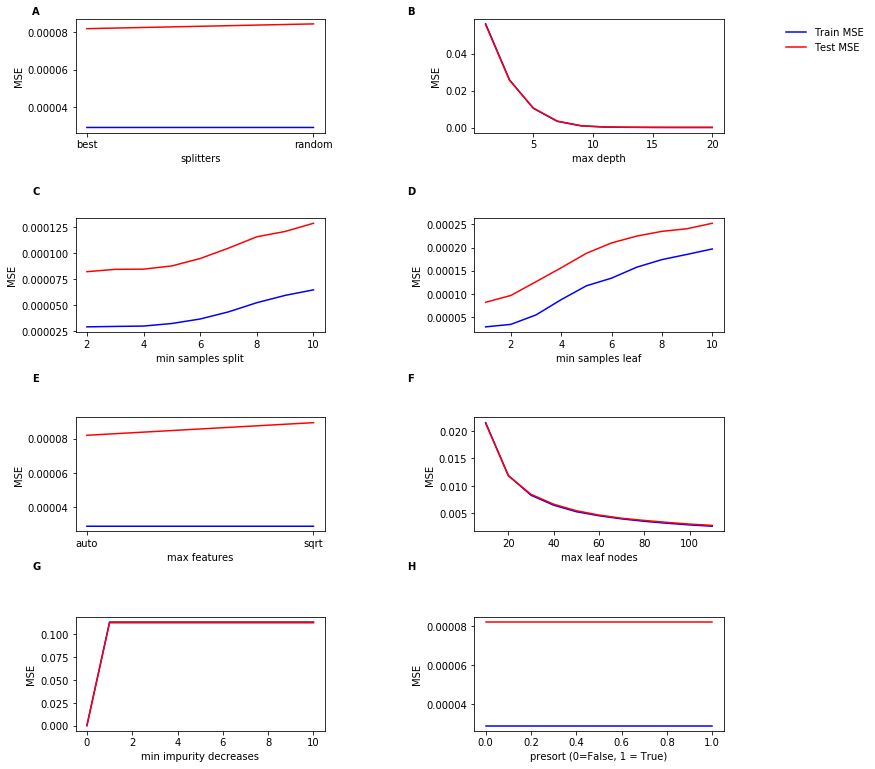

In [16]:
fig, axes = plt.subplots(4,2,figsize=(10,10),sharex=False, sharey=False)
fig.subplots_adjust(left=0.09, bottom=0.001, right=0.99, top=0.99, wspace=0.6)
plt.subplots_adjust(hspace = 0.75)
#from matplotlib.legend_handler import HandlerLine2D

axes[0,0].plot(splitters, train_results_splitters, 'b', label= 'Train MSE')
axes[0,0].plot(splitters, test_results_splitters, 'r', label= 'Test MSE')
axes[0,0].set(xlabel='splitters', ylabel='MSE')

axes[0, 1].plot(max_depths, train_results_maxdepth, 'b', label= 'Train MSE')
axes[0, 1].plot(max_depths, test_results_maxdepth, 'r', label= 'Test MSE')
axes[0, 1].set(xlabel='max depth', ylabel='MSE')

axes[1,0].plot(min_samples_splits, train_results_split, 'b', label= 'Train MSE')
axes[1,0].plot(min_samples_splits, test_results_split, 'r', label= 'Test MSE')
axes[1,0].set(xlabel='min samples split', ylabel='MSE')

axes[1, 1].plot(min_samples_leafs, train_results_samples, 'b', label= 'Train MSE')
axes[1, 1].plot(min_samples_leafs, test_results_samples, 'r', label= 'Test MSE')
axes[1, 1].set(xlabel='min samples leaf', ylabel='MSE')

axes[2,0].plot(max_features, train_results_features, 'b', label= 'Train MSE')
axes[2,0].plot(max_features, test_results_features, 'r', label= 'Test MSE')
axes[2,0].set(xlabel='max features', ylabel='MSE')

axes[2,1].plot(max_leaf_nodes, train_results_nodes, 'b', label= 'Train MSE')
axes[2,1].plot(max_leaf_nodes, test_results_nodes, 'r', label= 'Test MSE')
axes[2,1].set(xlabel='max leaf nodes', ylabel='MSE')

axes[3,0].plot(min_impurity_decreases, train_results_imp, 'b', label= 'Train MSE')
axes[3,0].plot(min_impurity_decreases, test_results_imp, 'r', label= 'Test MSE')
axes[3,0].set(xlabel='min impurity decreases', ylabel='MSE')

axes[3,1].plot(presorts, train_results_presort, 'b', label= 'Train MSE')
axes[3,1].plot(presorts, test_results_presort, 'r', label= 'Test MSE')
axes[3,1].set(xlabel='presort (0=False, 1 = True)', ylabel='MSE')

axes[0, 1].legend(['Train MSE','Test MSE'],bbox_to_anchor=(1.6,1),frameon=False)


fig.text(0.03, 1, "A", weight="bold", horizontalalignment='left', verticalalignment='center')
fig.text(0.55, 1,"B", weight="bold", horizontalalignment='left', verticalalignment='center')
fig.text(0.03, 0.75, "C", weight="bold", horizontalalignment='left', verticalalignment='center')
fig.text(0.55, 0.75, "D", weight="bold", horizontalalignment='left', verticalalignment='center')
fig.text(0.03, 0.49, "E", weight="bold", horizontalalignment='left', verticalalignment='center')
fig.text(0.55, 0.49, "F", weight="bold", horizontalalignment='left', verticalalignment='center')
fig.text(0.03, 0.23, "G", weight="bold", horizontalalignment='left', verticalalignment='center')
fig.text(0.55, 0.23, "H", weight="bold", horizontalalignment='left', verticalalignment='center')

In [78]:
best_params_all=dict()
cv_results_all=dict()
best_estimator_all=dict()
tree_random=()

#

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 10 fold cross validation, 
# search across 100 different combinations, and use all available cores
# scoring = none, use default model score (MSE)
_ = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
tree_random = RandomizedSearchCV(estimator = pipeline, param_distributions = random_grid, random_state=42,
                               n_iter = 500, cv = 5, verbose=0)

#print(mse)
# Fit the random search model
tree_random.fit(X_train, y_train)
y_pred=tree_random.predict(X_test)

nrmse=np.sqrt(mean_squared_error(y_test, y_pred))/(np.max(y_test)-np.min(y_test))
score=r2_score(y_test,y_pred)

print(nrmse)
print(score)
print(tree_random.best_params_)
print(tree_random.best_estimator_)

0.058160211780380805
0.9777881879345146
{'reg__splitter': 'best', 'reg__presort': True, 'reg__min_samples_split': 5, 'reg__min_samples_leaf': 1, 'reg__min_impurity_decrease': 0, 'reg__max_leaf_nodes': 110, 'reg__max_features': 'auto', 'reg__max_depth': 13}
PipelineRFE(memory=None,
            steps=[('reg',
                    DecisionTreeRegressor(criterion='mse', max_depth=13,
                                          max_features='auto',
                                          max_leaf_nodes=110,
                                          min_impurity_decrease=0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=5,
                                          min_weight_fraction_leaf=0.0,
                                          presort=True, random_state=42,
                                          splitter='best'))],
            verbose=False)


In [79]:
tree_random

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=PipelineRFE(memory=None,
                                         steps=[('reg',
                                                 DecisionTreeRegressor(criterion='mse',
                                                                       max_depth=None,
                                                                       max_features=None,
                                                                       max_leaf_nodes=None,
                                                                       min_impurity_decrease=0.0,
                                                                       min_impurity_split=None,
                                                                       min_samples_leaf=1,
                                                                       min_samples_split=2,
                                                                       min_weight_fraction_leaf=0.

In [80]:
#refit the tree using the best paramters on all of the data
best_reg=tree_random.best_estimator_
# tree_random.best_params_
# tree_random.refit
best_reg

PipelineRFE(memory=None,
            steps=[('reg',
                    DecisionTreeRegressor(criterion='mse', max_depth=13,
                                          max_features='auto',
                                          max_leaf_nodes=110,
                                          min_impurity_decrease=0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=5,
                                          min_weight_fraction_leaf=0.0,
                                          presort=True, random_state=42,
                                          splitter='best'))],
            verbose=False)

# cross validation

In [81]:
mse_all=dict()
scores_all=dict()

def dict_to_df(d,name):
    df=pd.DataFrame(d.items(), columns=[name, 'value'])
    return df


def cv_10(X,y):
    """
    10-Folds cross-validator.
    Split dataset into 10 consecutive folds.
    Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
    """
        
    # splits X, Y  input data into X and y training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=True, random_state=42) 
    
    #specify regression tree model, cv
    cv = KFold(n_splits=5, random_state=42)

    #perform 10-fold cv, append 10 scores
    n=0
    for train_index, test_index in cv.split(X_train): 
        n=n+1
        # split X_train into 10 folds (10 different X_trains)
        X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
        # fit a decision tree regressor to the fold
        best_reg.fit(X_train_cv, y_train_cv)
        y_predicted = best_reg.predict(X_test_cv)

        cv_score=best_reg.score(X_test_cv, y_test_cv)
        mse=mean_squared_error(y_test_cv, y_predicted)
    
        mse_all.update({n:mse})
        scores_all.update({n:cv_score})

    return mse_all,scores_all


mse_all,scores_all=cv_10(X_all,y_all)
mse_all=dict_to_df(mse_all,'all')
scores_all=dict_to_df(scores_all,'all')

[Text(0, 0.5, 'R2'), Text(0.5, 0, 'all')]

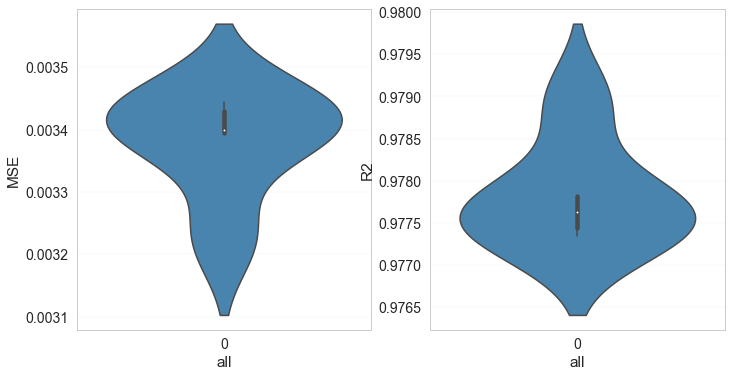

In [82]:
#plot
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True,figsize= (10,5))
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
fig.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.2)

sns.violinplot(data=mse_all['value'],ax=ax1,
                palette=("Blues_d")).set(xlabel='all',ylabel='MSE')  

sns.violinplot(data=scores_all['value'],ax=ax2,
                palette=("Blues_d")).set(xlabel='all',ylabel='R2')  

In [92]:
mse_allT=mse_all.T
mse_all
print(mse_all.describe())
print(scores_all.describe())

mse_all['value'].mean()

            all     value
count  5.000000  5.000000
mean   3.000000  0.003379
std    1.581139  0.000087
min    1.000000  0.003228
25%    2.000000  0.003394
50%    3.000000  0.003399
75%    4.000000  0.003430
max    5.000000  0.003444
            all     value
count  5.000000  5.000000
mean   3.000000  0.977832
std    1.581139  0.000642
min    1.000000  0.977340
25%    2.000000  0.977438
50%    3.000000  0.977634
75%    4.000000  0.977817
max    5.000000  0.978932


0.003379010562701822

In [111]:
from textwrap import wrap
def plot_prediction(X,y,ax):
    """
    10-Folds cross-validator.
    Split dataset into 10 consecutive folds.
    Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
    """
        
    # splits X, Y  input data into X and y training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=True, random_state=42) 
    
    #specify regression tree model, cv
    cv_predict=cross_val_predict(best_reg, X_test, y_test, cv=5)

    #plot predicted vs. actual
#     f, ax = plt.subplots(1,figsize= (8,5))
#     sns.set(style='whitegrid', rc={"grid.linewidth": 0.1},font_scale=1.5)
#     f.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.2)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.scatter(y_test, cv_predict, color='grey',alpha = 0.1) 
    ax.set_xlabel('Measured (PySWMM)')
    plt.grid(axis='x')

    ax.set_ylabel("Predicted \n%s" % "\n".join(wrap("(regression with 10-fold CV)")))
#     ax.set_title("Measured vs Predicted $ɸ_{var}$",fontdict = {'fontsize' : 20})
    ax.text(0.01,.7, r'$r^2$ = '+str(round(scores_all['value'].mean(),3))+
            "\n"
            '$MSE$ = ' +str(round(mse_all['value'].mean(),4)))

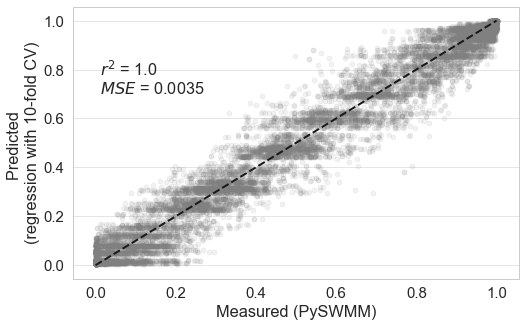

In [112]:
f, ax = plt.subplots(1,figsize= (8,5))

plot_prediction(X_all,y_all,ax)

# Random state sensitivity

In [105]:
mse_all=dict()
scores_all=dict()

def random_state(X,y):
    """

    """
    # splits X, Y  input data into X and y training and testing sets
    randomstate=np.random.randint(100,100000,30)
    for i in randomstate:
         # splits X, Y  input data into X and y training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,shuffle=True, random_state=i) 

        tree=DecisionTreeRegressor(random_state=i)
        tree.fit(X_train, y_train)
        y_pred=tree.predict(X_test)
        
        score=r2_score(y_test,y_pred)
        mse=mean_squared_error(y_test,y_pred)
    
        mse_all.update({i:mse})
        scores_all.update({i:score})

    return mse_all,scores_all

random_state(X_all,y_all)
mse_all=dict_to_df(mse_all,'all')
scores_all=dict_to_df(scores_all,'all')

[(0.9, 1.1), Text(0, 0.5, 'R2'), Text(0.5, 0, 'random seed')]

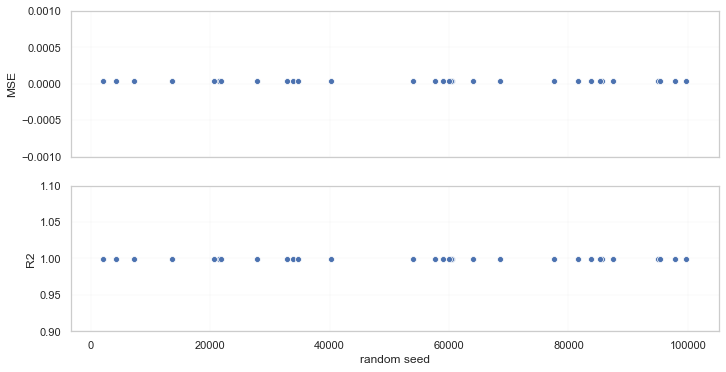

In [106]:
#plot

fig, (ax1, ax2) = plt.subplots(2,sharex=True,figsize= (10,5))
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
fig.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.2)

sns.scatterplot(x='all', y="value", data=mse_all,ax=ax1,
                palette=("Blues_d")).set(ylim=(-0.001, 0.001),xlabel='random seed',ylabel='MSE')  

sns.scatterplot(x="all", y="value", data=scores_all,ax=ax2,
                palette=("Blues_d")).set(ylim=(0.9,1.1),xlabel='random seed',ylabel='R2')  

# feature importance

In [107]:
importance_all=dict()
mse_all=dict()

def feature_imp(X,y):
    """
    
    """
    importance=dict()
    mse=dict()
    # splits X, Y  input data into X and y training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=True, random_state=42) 
    
    #specify regression tree model, cv
    cv = KFold(n_splits=5, random_state=42,shuffle=True)

    #perform 10-fold cv, append 10 scores
    best_reg
    n=0
    for train_index, test_index in cv.split(X_train): 
        n=n+1
        # split X_train into 10 folds (10 different X_trains)
        X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
        # fit a decision tree regressor to the fold
        best_reg.fit(X_train_cv, y_train_cv)
        y_predicted = best_reg.predict(X_test_cv)
        
        importance=dict(zip(features_print, best_reg.feature_importances_))
        importance_all.update({n:importance})
        mse=mean_squared_error(y_test_cv, y_predicted)
        mse_all.update({n:mse})

    return mse_all,scores_all
feature_imp(X_all,y_all)
mse_all=dict_to_df(mse_all,'all')
importance_all=pd.DataFrame.from_dict(importance_all)
importance_all=importance_all.stack().reset_index()

Text(0.54, 1, 'B')

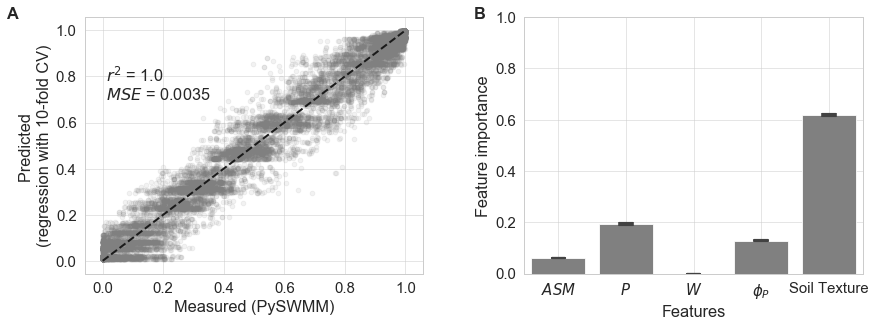

In [109]:
%matplotlib inline
f, axes = plt.subplots(1,2,figsize= (12,4))
sns.set("paper","whitegrid", rc={"grid.linewidth": 0.5},font_scale=1.7)
f.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.2)
plt.subplots_adjust(wspace = 0.3)
axes[1]=sns.barplot(y=0, x= "level_0", data=importance_all,  orient='v',
            color=("Grey"), capsize=.2).set(xlabel='Features',ylabel='Feature importance',ylim=(0,1)) 
plot_prediction(X_all,y_all,axes[0])
#plt.title("Importance of input features in predicting $ɸ_{var}$")

f.text(0, 1, "A", weight="bold", horizontalalignment='left', verticalalignment='center')
f.text(0.54, 1,"B", weight="bold", horizontalalignment='left', verticalalignment='center')

In [110]:
from matplotlib.font_manager import FontProperties
# Get numerical feature importances
importances = list(best_reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_print, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
imp_df=pd.DataFrame.from_dict(feature_importances)
imp_df=imp_df.rename(columns={0: "feature", 1: "importance"})
imp_df

,feature,importance
0,Soil Texture,0.62
1,$P$,0.19
2,$ɸ_P$,0.13
3,$ASM$,0.06
4,$W$,0.00


# Feature importances - subsets

In [44]:
feature_names=selected_features
df.P_cm.unique()

array([ 1.5,  2.5,  5.1,  7.6, 10.2])

In [45]:
#import soil file

sand=df.loc[df['Ks_mm'] ==120.4]
clay=df.loc[df['Ks_mm'] ==0.3]

P_low=df.loc[df['P_cm'] ==1.5]
P_high=df.loc[df['P_cm'] ==10.2]

fV_low=df.loc[df['fV'] <=0.2]
fV_high=df.loc[df['fV'] >=0.8]

df_sat=df.loc[df['SoilConditions'] ==1]
df_fc=df.loc[df['SoilConditions'] ==2]
df_wp=df.loc[df['SoilConditions'] ==3]

In [46]:
tabke = pd.pivot_table(df, values='f_var', index=['P_cm'],
                    aggfunc={np.mean,np.sum,np.std})

len(P_high)

12000

In [47]:
# split into X and y datasets
#multiple X's

X_sand = sand[feature_names].values 
X_clay = clay[feature_names].values 

#one Y
y_sand = pd.DataFrame(sand['f_var']).values.ravel() 
y_clay = pd.DataFrame(clay['f_var']).values.ravel() 

X_06 = P_low[feature_names].values 
X_4 = P_high[feature_names].values 

#one Y
y_06 = pd.DataFrame(P_low['f_var']).values.ravel() 
y_4 = pd.DataFrame(P_high['f_var']).values.ravel() 
  
# split into X and y datasets
#multiple X's

X_fV_low = fV_low[feature_names].values 
X_fV_high = fV_high[feature_names].values 

#one Y
y_fV_low = pd.DataFrame(fV_low['f_var']).values.ravel() 
y_fV_high = pd.DataFrame(fV_high['f_var']).values.ravel() 

# split into X and y datasets
#multiple X'

X_sat = df_sat[feature_names].values 
X_fc = df_fc[feature_names].values 
X_wp = df_wp[feature_names].values 

#one Y
y_sat = pd.DataFrame(df_sat['f_var']).values.ravel() 
y_fc = pd.DataFrame(df_fc['f_var']).values.ravel() 
y_wp = pd.DataFrame(df_wp['f_var']).values.ravel() 

In [48]:
importance_all=dict()
mse_all=dict()
feature_imp(X_sand,y_sand)
importance_sand=pd.DataFrame.from_dict(importance_all)
importance_sand=importance_sand.stack().reset_index()
importance_sand['n']=len(sand)
importance_sand['scenario']='Sand ($K_s$ = 120.4 mm/hr), n =' +str(int(importance_sand['n'].mean()))

importance_all=dict()
mse_all=dict()
feature_imp(X_clay,y_clay)
importance_clay=pd.DataFrame.from_dict(importance_all)
importance_clay=importance_clay.stack().reset_index()
importance_clay['n']=len(clay)
importance_clay['scenario']='Clay ($K_s$ = 0.3 mm/hr), n =' +str(int(importance_clay['n'].mean()))

importance_soil=pd.concat([importance_clay,importance_sand])

importance_all=dict()
mse_all=dict()
feature_imp(X_06,y_06)
importance_lowp=pd.DataFrame.from_dict(importance_all)
importance_lowp=importance_lowp.stack().reset_index()
importance_lowp['n']=len(P_low)
importance_lowp['scenario']='P = 2.5 cm, n =' +str(int(importance_lowp['n'].mean()))

importance_all=dict()
mse_all=dict()
feature_imp(X_4,y_4)
importance_highP=pd.DataFrame.from_dict(importance_all)
importance_highP=importance_highP.stack().reset_index()
importance_highP['n']=len(P_high)
importance_highP['scenario']='P = 10.2 cm, n =' +str(int(importance_highP['n'].mean()))

importance_p=pd.concat([importance_lowp,importance_highP])

importance_all=dict()
mse_all=dict()
feature_imp(X_fV_low,y_fV_low)
importance_fv_low=pd.DataFrame.from_dict(importance_all)
importance_fv_low=importance_fv_low.stack().reset_index()
importance_fv_low['n']=len(fV_low)
importance_fv_low['scenario']='$ɸ_P$<0.2, n =' +str(int(importance_fv_low['n'].mean()))

importance_all=dict()
mse_all=dict()
feature_imp(X_fV_high,y_fV_high)
importance_fv_high=pd.DataFrame.from_dict(importance_all)
importance_fv_high=importance_fv_high.stack().reset_index()
importance_fv_high['n']=len(fV_high)
importance_fv_high['scenario']='$ɸ_P$>0.8, n =' +str(int(importance_fv_high['n'].mean()))

importance_fv=pd.concat([importance_fv_low,importance_fv_high])

importance_all=dict()
mse_all=dict()
feature_imp(X_sat,y_sat)
importance_sat=pd.DataFrame.from_dict(importance_all)
importance_sat=importance_sat.stack().reset_index()
importance_sat['n']=len(df_sat)
importance_sat['scenario']='Saturated, n =' +str(int(importance_sat['n'].mean()))

importance_all=dict()
mse_all=dict()
feature_imp(X_wp,y_wp)
importance_wp=pd.DataFrame.from_dict(importance_all)
importance_wp=importance_wp.stack().reset_index()
importance_wp['n']=len(df_wp)
importance_wp['scenario']='Wilting Point, n =' +str(int(importance_wp['n'].mean()))

importance_asm=pd.concat([importance_sat,importance_wp])

importance_all=pd.concat([importance_fv,importance_soil,importance_asm,importance_p])
count=importance_all[['scenario','n']]
ma = count.groupby(['scenario']).mean().reset_index()
ma.sort_values('n')

,scenario,n
2,"Clay ($K_s$ = 0.3 mm/hr), n =6000",6000
5,"Sand ($K_s$ = 120.4 mm/hr), n =6000",6000
3,"P = 10.2 cm, n =12000",12000
4,"P = 2.5 cm, n =12000",12000
0,"$ɸ_P$<0.2, n =12600",12600
1,"$ɸ_P$>0.8, n =13200",13200
6,"Saturated, n =20000",20000
7,"Wilting Point, n =20000",20000


Text(0.54, 0.49, 'D')

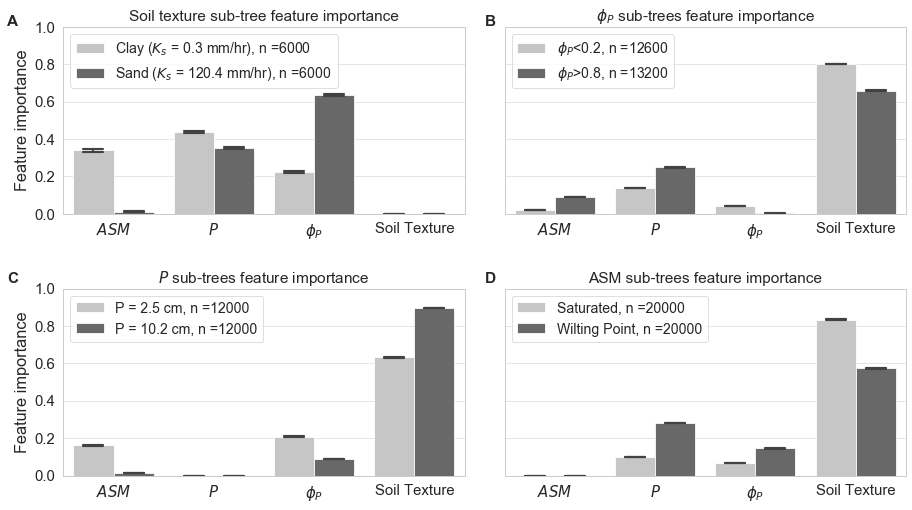

In [49]:
f, axes = plt.subplots(2,2,sharey=True,figsize= (13,7))
sns.set("paper",'whitegrid', rc={"grid.linewidth": 0.1},font_scale=1.6)
f.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.1)
plt.subplots_adjust(hspace = 0.4)

bar=sns.barplot(y=0, x= "level_0", data=importance_soil,  orient='v',
                palette="Greys",
            hue='scenario',capsize=.2,ax=axes[0][0]).set(
    xlabel='',ylabel='Feature importance',title='Soil texture sub-tree feature importance', ylim=(0,1))  
axes[0][0].legend(title = '', loc = 'upper left')

sns.barplot(y=0, x= "level_0", data=importance_p,  orient='v',hue='scenario',
            palette="Greys",  capsize=.2,ax=axes[1][0]).set(
    xlabel='',ylabel='Feature importance',title='$P$ sub-trees feature importance')  
axes[1][0].legend(title = '', loc = 'upper left')


sns.barplot(y=0, x= "level_0", data=importance_fv,  orient='v',hue='scenario',
            palette='Greys',  capsize=.2,ax=axes[0][1]).set(
    xlabel='',ylabel='',title='$ɸ_P$ sub-trees feature importance')  
axes[0][1].legend(title = '', loc = 'upper left')


sns.barplot(y=0, x= "level_0", data=importance_asm,  orient='v',hue='scenario',
            palette='Greys', capsize=.2,ax=axes[1][1]).set(
    xlabel='',ylabel='',title='ASM sub-trees feature importance')  
axes[1][1].legend(title = '', loc = 'upper left')


f.text(0.03, 1, "A", weight="bold", horizontalalignment='left', verticalalignment='center')
f.text(0.54, 1,"B", weight="bold", horizontalalignment='left', verticalalignment='center')
f.text(0.03, 0.49, "C", weight="bold", horizontalalignment='left', verticalalignment='center')
f.text(0.54, 0.49, "D", weight="bold", horizontalalignment='left', verticalalignment='center')

In [50]:
importance_all=pd.concat([importance_fv,importance_soil,importance_asm,importance_p])
count=importance_all[['scenario','n']]
ma = count.groupby(['scenario']).mean().reset_index()
ma['m_pct']=round(ma['n']/60000*100)
ma.sort_values('n')


,scenario,n,m_pct
2,"Clay ($K_s$ = 0.3 mm/hr), n =6000",6000,10.0
5,"Sand ($K_s$ = 120.4 mm/hr), n =6000",6000,10.0
3,"P = 10.2 cm, n =12000",12000,20.0
4,"P = 2.5 cm, n =12000",12000,20.0
0,"$ɸ_P$<0.2, n =12600",12600,21.0
1,"$ɸ_P$>0.8, n =13200",13200,22.0
6,"Saturated, n =20000",20000,33.0
7,"Wilting Point, n =20000",20000,33.0


In [51]:
# split into X and y datasets
#multiple X's

X_06 = P_low[feature_names].values 
X_4 = P_low[feature_names].values 

#one Y
y_06 = pd.DataFrame(P_low['f_var']).values.ravel() 
y_4 = pd.DataFrame(P_low['f_var']).values.ravel() 


X_fV_low = fV_low[feature_names].values 
X_fV_high = fV_high[feature_names].values 

#one Y
y_fV_low = pd.DataFrame(fV_low['f_var']).values.ravel() 
y_fV_high = pd.DataFrame(fV_high['f_var']).values.ravel() 


X_sat = df_sat[feature_names].values 
X_fc = df_fc[feature_names].values 
X_wp = df_wp[feature_names].values 
#one Y
Y_sat = pd.DataFrame(df_sat['f_var']).values.ravel() 
Y_fc = pd.DataFrame(df_fc['f_var']).values.ravel() 
Y_wp = pd.DataFrame(df_wp['f_var']).values.ravel() 

# Train on all data

In [52]:
from sklearn import tree
best_reg.fit(X_all,y_all)
best_reg['reg']

DecisionTreeRegressor(criterion='mse', max_depth=13, max_features='auto',
                      max_leaf_nodes=110, min_impurity_decrease=0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      presort=True, random_state=42, splitter='best')

In [59]:
from sklearn import tree

from sklearn.tree import _tree
def tree_to_code(tree, feature_names):

    '''
    Outputs a decision tree model as a Python function

    Parameters:
    -----------
    tree: decision tree model
        The decision tree to represent as a function
    feature_names: list
        The feature names of the dataset used for building the decision tree
    '''

    
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("for row in cursor:")
    
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if ({} <= {}):".format(indent,name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}elif ({} > {}):".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}row[4]={}".format(indent, str(tree_.value[node])[2:-2]))
            print("  " * depth + "cursor.updateRow(row)".format(indent))
            

    recurse(0, 1)

In [60]:
selected_features

['fV', 'P_cm', 'SoilConditions', 'Ks_mm']

In [62]:
data_feature_names = ["row[0]", "row[1]", "row[2]", "row[3]", "row[4]"]
tree_to_code(best_reg['reg'], list(data_feature_names))

for row in cursor:
  if (row[3] <= 4.949999928474426):
    if (row[1] <= 3.799999952316284):
      if (row[3] <= 0.800000011920929):
        if (row[2] <= 1.5):
          if (row[3] <= 0.4000000059604645):
            row[4]=0.97865875
            cursor.updateRow(row)
          elif (row[3] > 0.4000000059604645):
            if (row[0] <= 0.5062019973993301):
              row[4]=0.93305227
              cursor.updateRow(row)
            elif (row[0] > 0.5062019973993301):
              if (row[1] <= 2.0):
                row[4]=0.76493333
                cursor.updateRow(row)
              elif (row[1] > 2.0):
                row[4]=0.869275
                cursor.updateRow(row)
        elif (row[2] > 1.5):
          if (row[0] <= 0.2981559932231903):
            if (row[0] <= 0.14532233774662018):
              row[4]=0.89344048
              cursor.updateRow(row)
            elif (row[0] > 0.14532233774662018):
              if (row[1] <= 2.0):
                row[4]=0.70315705
   